C:\Users\kimve\AppData\Local\Temp\ipykernel_112364\569415454.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  timestamps = row[1][0]
C:\Users\kimve\AppData\Local\Temp\ipykernel_112364\569415454.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tags = row[1][1]


[1048.35164835 1039.56043956 1030.76923077 ... 1072.52747253 1063.003663
 1052.74725275]
[1.74340551e+12 1.74340551e+12 1.74340551e+12 ... 1.74340563e+12
 1.74340563e+12 1.74340563e+12]
Extracted 23629 PPG samples for baseline period
First few values: [1048.35164835 1039.56043956 1030.76923077 1025.64102564 1017.58241758]
Extracted 106551 PPG samples for baseline period
First few values: [1043.95604396 1039.56043956 1039.56043956 1041.75824176 1048.35164835]


c:\Users\kimve\AppData\Local\Programs\Python\Python312\Lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Extracted 303098 PPG samples for baseline period
First few values: [1379.48717949 1370.6959707  1358.97435897 1350.18315018 1340.65934066]


<Figure size 1200x600 with 0 Axes>

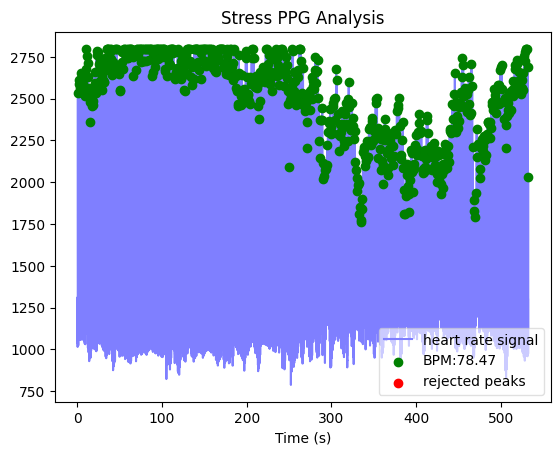

<Figure size 1200x600 with 0 Axes>

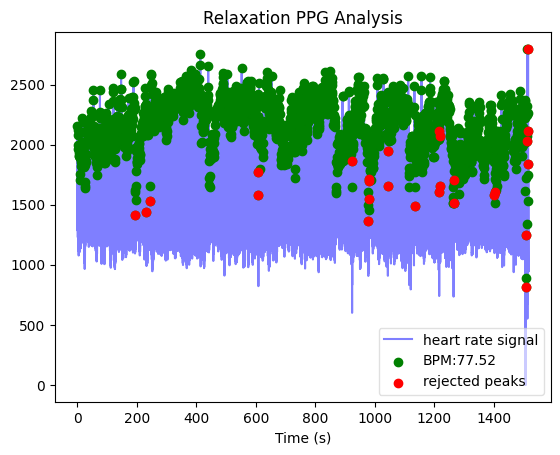

In [ ]:
# WORKING PPG DATA ANALYSIS TEST ONE PARTICIPANT

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import heartpy as hp

# import file
fp = 'DataForKim/shimmers_03-31-2025_ID031/Shimmer_C7CA_Session2_Shimmer_C7CA_Calibrated_PC.csv'
df = pd.read_csv(fp, sep=',', decimal=',', skiprows=1)
df.head()

# rename to time_col
df['time_col'] = df['Shimmer_C7CA_TimestampSync_Unix_CAL']

# convert from scientific notation to integers to match timestamps csv
for t in df['time_col'][1:]:
    converted_t = float(str(t).replace(',', '.'))
    converted_t = (int(converted_t))
    t = converted_t
    # print(t)

# now permanently and exclude first row as it contains 'ms'
df_clean = df.copy()
clean_rows = df_clean.index[1:] 
df_clean.loc[clean_rows, 'time_col'] = (df_clean.loc[clean_rows, 'time_col'].astype(str).str.replace(',', '.').astype(float).astype('int64'))

# import timestamps and find the phases
ts_file = pd.read_csv('031_timestamps(in).csv') # adjust to exclude header

# baseline_range = ts_file[ts_file['tag'] == 'baseline']['timestamp'].tolist()
# stress_range = ts_file[ts_file['tag'] == 'stress']['timestamp'].tolist()
# relaxation_range = ts_file[ts_file['tag'] == 'relaxation']['timestamp'].tolist()

baseline_range = []
stress_range = []
relaxation_range = []

for row in ts_file.iterrows():
    timestamps = row[1][0]
    tags = row[1][1]
    
    # extract phase start/end pairs per phase
    if tags == 'baseline':
        baseline_range.append(timestamps)
    if tags == 'stress':
        stress_range.append(timestamps)
    if tags == 'relaxation':
        relaxation_range.append(timestamps)

# match start/end pairs up with time in timecolumn or find closest
def closest_ts(target, time_col_ts):
    target = int(target)

    valid_timestamps = time_col_ts[time_col_ts != 'ms'].copy()
    valid_timestamps = pd.to_numeric(valid_timestamps, errors='coerce').dropna()
    
    # convert to integers (check if scientific notation convertion above works?)
    valid_timestamps = valid_timestamps.astype('int64')

    # find the closest index
    closest_index = (np.abs(target - valid_timestamps)).argmin()
    return int(valid_timestamps.iloc[closest_index])

# append to the list for each phase, the start and end timestamp
baseline_start = closest_ts(baseline_range[0], df_clean['time_col'])
baseline_end = closest_ts(baseline_range[1], df_clean['time_col'])

stress_start = closest_ts(stress_range[0], df_clean['time_col'])
stress_end = closest_ts(stress_range[1], df_clean['time_col'])

relaxation_start = closest_ts(relaxation_range[0], df_clean['time_col'])
relaxation_end = closest_ts(relaxation_range[1], df_clean['time_col'])

# print(baseline_start)
# print(baseline_end)
# print(round((baseline_end - baseline_start) /60000 )) # get the minutes it lasted
# # check! in this case returns raw 1.96 and using round 2 which is correct because baseline is around 2 min

# get the ppg  signal range that matches the timestamps we just found for start and end
df['ppg_signal'] = df['Shimmer_C7CA_PPG_A13_CAL']

df_numeric = df.copy()
df_numeric['time_col'] = pd.to_numeric(df_numeric['time_col'], errors='coerce')
df_numeric['ppg_signal'] = pd.to_numeric(df_numeric['ppg_signal'], errors='coerce')

# remove header rows as constant errors because of it being a str
df_numeric = df_numeric.dropna(subset=['time_col', 'ppg_signal'])

# rows of just that phase
baseline_data = df_numeric[(df_numeric['time_col'] >= baseline_start) & (df_numeric['time_col'] <= baseline_end)].copy()

# extract ppg singal from phase rows
baseline_ppg = baseline_data['ppg_signal'].values
baseline_time = baseline_data['time_col'].values
print(baseline_ppg)
print(baseline_time)

print(f"Extracted {len(baseline_ppg)} PPG samples for baseline period")
print(f"First few values: {baseline_ppg[:5]}")

# now using heartpy to process the ppg signal
try:
    # process the ppg signal
    wd, m = hp.process(baseline_ppg, sample_rate=200)
    
    # plot
    # plt.figure(figsize=(12, 6))
    # hp.plotter(wd, m, title="Baseline PPG Analysis")

except Exception as e:
    print(f"Error processing with HeartPy: {e}")

    # if heartPy fails just plot the raw signal
    plt.figure(figsize=(12, 6))
    plt.plot(baseline_time, baseline_ppg)
    plt.title("Raw Baseline PPG Signal")
    plt.xlabel("Timestamp")
    plt.ylabel("PPG Value (mV)")
    plt.show()

# STRESS PHASE
# rows of just that phase
stress_data = df_numeric[(df_numeric['time_col'] >= stress_start) & (df_numeric['time_col'] <= stress_end)].copy()

# extract ppg singal from phase rows
stress_ppg = stress_data['ppg_signal'].values
stress_time = stress_data['time_col'].values

print(f"Extracted {len(stress_ppg)} PPG samples for baseline period")
print(f"First few values: {stress_ppg[:5]}")

# now use HeartPy
try:
    # process the ppg signal
    wd, m = hp.process(stress_ppg, sample_rate=200)
    
    # plot
    plt.figure(figsize=(12, 6))
    hp.plotter(wd, m, title="Stress PPG Analysis")

except Exception as e:
    print(f"Error processing with HeartPy: {e}")

    # if heartPy fails just plot the raw signal
    plt.figure(figsize=(12, 6))
    plt.plot(stress_time, stress_ppg)
    plt.title("Raw Stress PPG Signal")
    plt.xlabel("Timestamp")
    plt.ylabel("PPG Value (mV)")
    plt.show()

# RELAXATION PHASE
relaxation_data = df_numeric[(df_numeric['time_col'] >= relaxation_start) & (df_numeric['time_col'] <= relaxation_end)].copy()

relaxation_ppg = relaxation_data['ppg_signal'].values
relaxation_time = relaxation_data['time_col'].values

print(f"Extracted {len(relaxation_ppg)} PPG samples for baseline period")
print(f"First few values: {relaxation_ppg[:5]}")

# now let's use HeartPy
try:
    # process the ppg signal
    wd, m = hp.process(relaxation_ppg, sample_rate=200)
    
    # plot
    plt.figure(figsize=(12, 6))
    hp.plotter(wd, m, title="Relaxation PPG Analysis")

except Exception as e:
    print(f"Error processing with HeartPy: {e}")
    # if heartPy fails just plot the raw signal
    plt.figure(figsize=(12, 6))
    plt.plot(relaxation_time, relaxation_ppg)
    plt.title("Raw Relaxation PPG Signal")
    plt.xlabel("Timestamp")
    plt.ylabel("PPG Value (mV)")
    plt.show()

Skipping baseline for ID041 due to missing timestamps or invalid data.
Skipping stress for ID041 due to missing timestamps or invalid data.
Skipping relaxation for ID041 due to missing timestamps or invalid data.


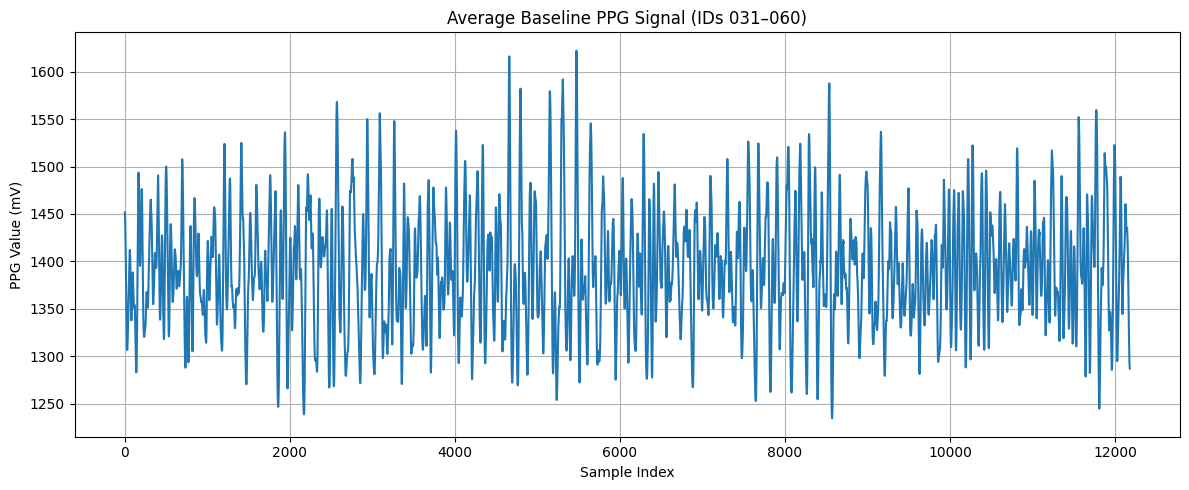

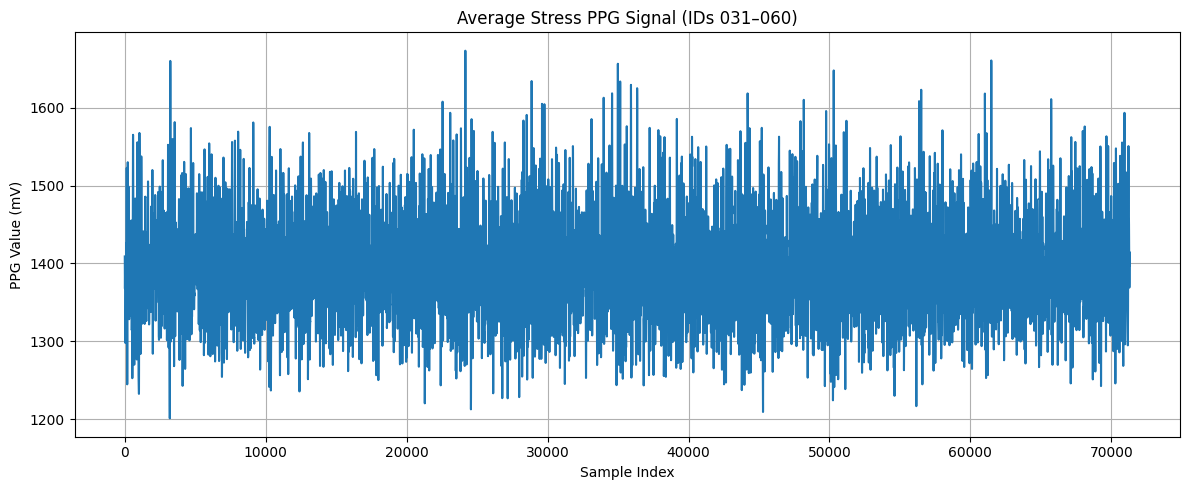

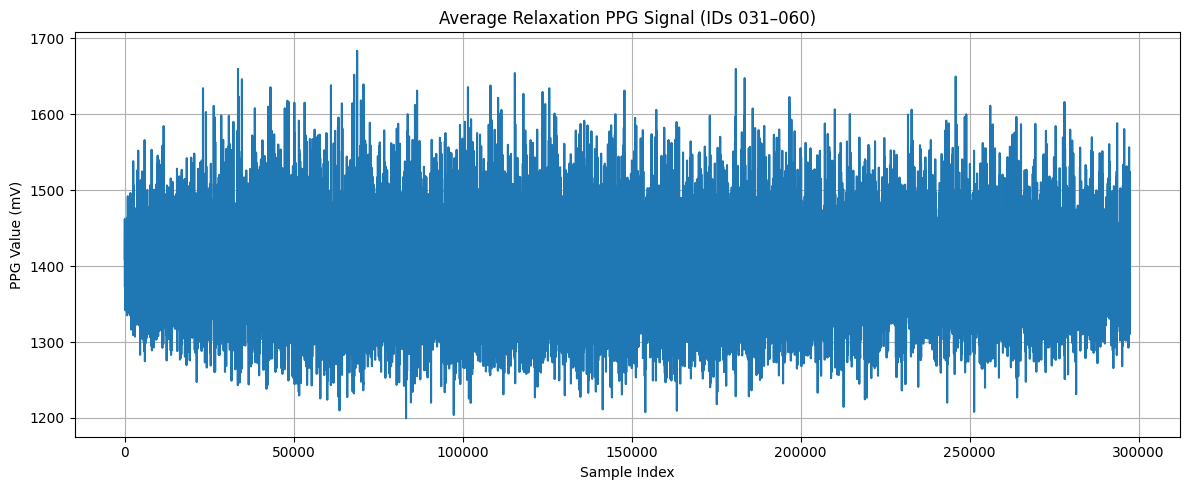

In [9]:
import os

# set root data folder
data_root = 'DataForKim'

# extract the participant IDs or 360VR
participant_ids = [f"{i:03}" for i in range(31, 61)]

# list per phase for PPG signals
all_baseline_ppg = []
all_stress_ppg = []
all_relaxation_ppg = []

# find the closest timestamp
def closest_ts(target, time_col_ts):
    valid_timestamps = pd.to_numeric(time_col_ts, errors='coerce').dropna()
    if valid_timestamps.empty:
        raise ValueError("No valid timestamps to compare against.")
    closest_index = (np.abs(valid_timestamps - int(target))).argmin()
    return int(valid_timestamps.iloc[closest_index])

for pid in participant_ids:
    shimmer_dir = None
    for folder in os.listdir(data_root):
        if f"ID{pid}" in folder:
            shimmer_dir = os.path.join(data_root, folder)
            break
    if shimmer_dir is None:
        print(f"Folder for ID{pid} not found, skipping.")
        continue
    
    shimmer_csv = [f for f in os.listdir(shimmer_dir) if f.startswith('Shimmer')]
    if not shimmer_csv:
        print(f"No shimmer file found for ID{pid}")
        continue
    shimmer_path = os.path.join(shimmer_dir, shimmer_csv[0])
    
    ts_csv = f'{pid}_timestamps.csv'
    ts_path = os.path.join(data_root, ts_csv)

    if not os.path.exists(ts_path):
        print(f"Timestamps file for ID{pid} not found.")
        continue

    try:
        df = pd.read_csv(shimmer_path, sep=',', decimal=',', skiprows=1)

        # use only numeric columns
        numeric_df = df.apply(pd.to_numeric, errors='coerce')
        time_col_name = numeric_df.columns[0]
        ppg_col_name = numeric_df.columns[4]

        df['time_col'] = pd.to_numeric(df[time_col_name].astype(str).str.replace(',', '.'), errors='coerce')
        df['ppg_signal'] = pd.to_numeric(df[ppg_col_name], errors='coerce')
        df = df.dropna(subset=['time_col', 'ppg_signal'])

        ts_df = pd.read_csv(ts_path)
        ts_dict = {'baseline': [], 'stress': [], 'relaxation': []}
        for _, row in ts_df.iterrows():
            ts_dict[row.iloc[1]].append(int(row.iloc[0]))

        for phase, container in [('baseline', all_baseline_ppg),
                                 ('stress', all_stress_ppg),
                                 ('relaxation', all_relaxation_ppg)]:
            try:
                if len(ts_dict[phase]) == 2 and not df['time_col'].isna().all():
                    start = closest_ts(ts_dict[phase][0], df['time_col'])
                    end = closest_ts(ts_dict[phase][1], df['time_col'])
                    segment = df[(df['time_col'] >= start) & (df['time_col'] <= end)]['ppg_signal'].values
                    if len(segment) > 0:
                        container.append(segment)
                    else:
                        print(f"Empty segment for phase {phase} in ID{pid}")
                else:
                    print(f"Skipping {phase} for ID{pid} due to missing timestamps or invalid data.")
            except Exception as e:
                print(f"Error processing phase {phase} for ID{pid}: {e}")
    except Exception as e:
        print(f"Error processing ID{pid}: {e}")

# normalize and average PPG segments by truncating to shortest length
def average_ppg(segments):
    if not segments:
        return np.array([])
    min_len = min(len(seg) for seg in segments)
    aligned = np.array([seg[:min_len] for seg in segments])
    return np.mean(aligned, axis=0)

# finally plot
def plot_avg(ppg_array, title):
    if len(ppg_array) == 0:
        print(f"No data to plot for {title}.")
        return
    plt.figure(figsize=(12, 5))
    plt.plot(ppg_array)
    plt.title(f"Average {title} PPG Signal (IDs 031–060)")
    plt.xlabel("Sample Index")
    plt.ylabel("PPG Value (mV)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# generate plots
if all_baseline_ppg:
    avg_baseline = average_ppg(all_baseline_ppg)
    plot_avg(avg_baseline, "Baseline")
if all_stress_ppg:
    avg_stress = average_ppg(all_stress_ppg)
    plot_avg(avg_stress, "Stress")
if all_relaxation_ppg:
    avg_relaxation = average_ppg(all_relaxation_ppg)
    plot_avg(avg_relaxation, "Relaxation")


c:\Users\kimve\AppData\Local\Programs\Python\Python312\Lib\site-packages\heartpy\analysis.py:677: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  interp = UnivariateSpline(x, rrlist, k=3)


    id    baseline      stress  relaxation
0  031   72.480772   78.453506   77.536102
1  032  104.343422  100.271500  105.250653
2  033  112.765438  101.596572  112.491353
3  034   74.045898   86.162249   78.532359
4  035   60.526196   64.776240   65.147785
Stress vs Baseline: t=1.69, p=0.102
Relaxation vs Stress: t=0.00, p=1.000


C:\Users\kimve\AppData\Local\Temp\ipykernel_112364\2664029008.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=melted, x='phase', y='HR', palette='coolwarm')


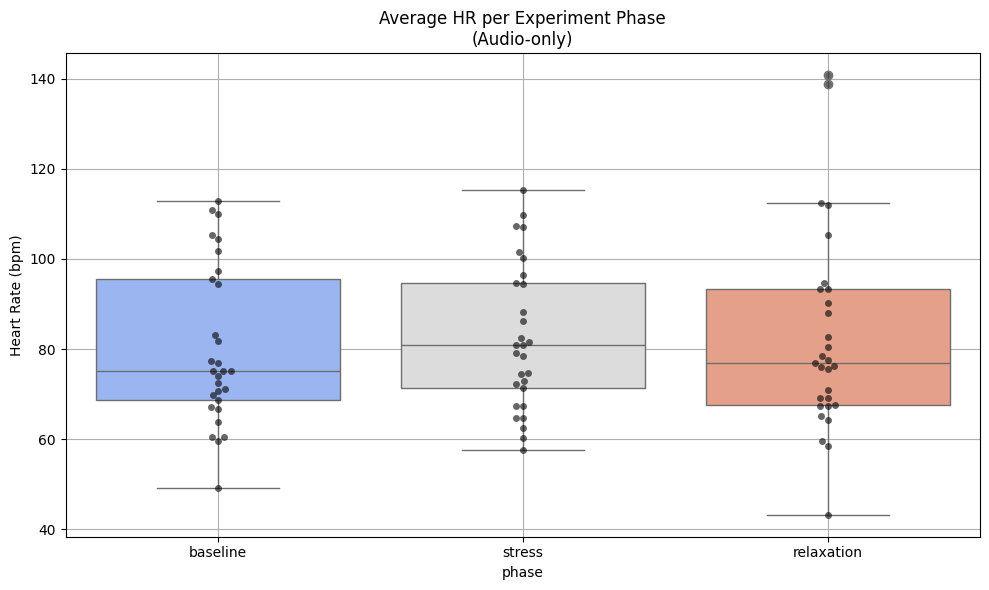

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, wilcoxon
import heartpy as hp

# function to get mean HR from PPG using HeartPy
from scipy.signal import butter, filtfilt

# bandpass filter
def bandpass_filter(signal, fs, low=0.5, high=4.0, order=2):
    nyq = 0.5 * fs
    low /= nyq
    high /= nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# updated function to preprocess and extract HR
def get_mean_hr(ppg_segment, sampling_rate):
    try:
        ppg_segment = np.nan_to_num(ppg_segment)
        ppg_segment = (ppg_segment - np.mean(ppg_segment)) / np.std(ppg_segment)
        
        # bandpass filter
        ppg_segment = bandpass_filter(ppg_segment, fs=sampling_rate)

        # process with HeartPy
        wd, m = hp.process(ppg_segment, sample_rate=sampling_rate)
        return m['bpm']
    except Exception as e:
        print(f"HR analysis failed: {e}")
        return np.nan

sampling_rate = 200 
participant_hr_data = []

for pid_idx, pid in enumerate(participant_ids):
    hr_record = {'id': pid}
    for phase, all_phase_ppg in zip(['baseline', 'stress', 'relaxation'],
                                    [all_baseline_ppg, all_stress_ppg, all_relaxation_ppg]):
        try:
            segment = all_phase_ppg[pid_idx]
            hr = get_mean_hr(segment, sampling_rate)
            hr_record[phase] = hr
        except IndexError:
            hr_record[phase] = np.nan
    participant_hr_data.append(hr_record)

hr_df = pd.DataFrame(participant_hr_data)
print(hr_df.head())

# drop rows with any missing values
paired_df = hr_df.dropna(subset=['baseline', 'stress', 'relaxation'])

# perform the paired t-tests
t_stat1, p_val1 = ttest_rel(paired_df['stress'], paired_df['baseline'])
print(f"Stress vs Baseline: t={t_stat1:.2f}, p={p_val1:.3f}")

t_stat2, p_val2 = ttest_rel(paired_df['relaxation'], paired_df['stress'])
print(f"Relaxation vs Stress: t={t_stat2:.2f}, p={p_val2:.3f}")

# use seaborn to visualize
melted = pd.melt(paired_df, id_vars='id', value_vars=['baseline', 'stress', 'relaxation'], var_name='phase', value_name='HR')

plt.figure(figsize=(10, 6))
sns.boxplot(data=melted, x='phase', y='HR', palette='coolwarm')
sns.swarmplot(data=melted, x='phase', y='HR', color='black', alpha=0.6)
plt.title('Average HR per Experiment Phase\n(Audio-only)')
plt.ylabel('Heart Rate (bpm)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
valid_hr_df = hr_df.dropna(subset=['baseline', 'stress', 'relaxation'])

# Mean and standard deviation per phase
means = valid_hr_df[['baseline', 'stress', 'relaxation']].mean()
stds = valid_hr_df[['baseline', 'stress', 'relaxation']].std()
medians = valid_hr_df[['baseline', 'stress', 'relaxation']].median()


print("Mean HR per phase (bpm):")
print(means)
print("\nStandard Deviation per phase (bpm):")
print(stds)
print("\nMedian per phase (bpm):")
print(medians)

# t-test to comoare relaxation to baseline
from scipy.stats import ttest_rel

t_stat, p_val = ttest_rel(valid_hr_df['relaxation'], valid_hr_df['baseline'])
print(f"\nRelaxation vs Baseline: T= {t_stat:.3f}, p= {p_val:.3f}")


Mean HR per phase (bpm):
baseline      80.371610
stress        82.573174
relaxation    82.574315
dtype: float64

Standard Deviation per phase (bpm):
baseline      17.643720
stress        16.207537
relaxation    22.351629
dtype: float64

Median per phase (bpm):
baseline      75.082438
stress        80.862370
relaxation    76.853906
dtype: float64

Relaxation vs Baseline: T= 0.533, p= 0.598
